In [1]:
# =========================================
# 📌 Diabetes Readmission Prediction Project
# =========================================

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1️⃣ Load Dataset
# ----------------------------
df = pd.read_csv("diabetic_data.csv")
print("Initial Shape:", df.shape)

Initial Shape: (77599, 50)


In [3]:
# ----------------------------
# 2️⃣ Drop Unnecessary Columns
# ----------------------------
# 'encounter_id' and 'patient_nbr' are just IDs (no predictive power)
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

# ----------------------------
# 3️⃣ Handle Missing Value Symbols
# ----------------------------
# Replace '?' with NaN for proper handling
df.replace('?', np.nan, inplace=True)

In [5]:
# ----------------------------
# 4️⃣ Encode Target Variable
# ----------------------------
# '<30' → 1 (Readmitted within 30 days)
# '>30' or 'NO' → 0
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [7]:
# ----------------------------
# 5️⃣ Handle Missing Values
# ----------------------------
# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

In [9]:
# Fill remaining NaN values with most frequent value (mode)
df.fillna(df.mode().iloc[0], inplace=True)

In [11]:
# ----------------------------
# 6️⃣ Encode Categorical Variables
# ----------------------------
# Convert categorical variables into numeric dummy variables
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [13]:
# ----------------------------
# 7️⃣ Display Final Dataset Info
# ----------------------------
print("Final Shape after preprocessing:", df.shape)
print(df.head())

Final Shape after preprocessing: (77599, 2296)
   admission_type_id  discharge_disposition_id  admission_source_id  \
0                6.0                      25.0                  1.0   
1                1.0                       1.0                  7.0   
2                1.0                       1.0                  7.0   
3                1.0                       1.0                  7.0   
4                1.0                       1.0                  7.0   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0               1.0                41.0             0.0              1.0   
1               3.0                59.0             0.0             18.0   
2               2.0                11.0             5.0             13.0   
3               2.0                44.0             1.0             16.0   
4               1.0                51.0             0.0              8.0   

   number_outpatient  number_emergency  number_inpatient  ...  insuli

In [17]:
# Save preprocessed data
df.to_csv("preprocessed_diabetic_data.csv", index=False)
print("✅ Preprocessed dataset saved as 'preprocessed_diabetic_data.csv'")

✅ Preprocessed dataset saved as 'preprocessed_diabetic_data.csv'


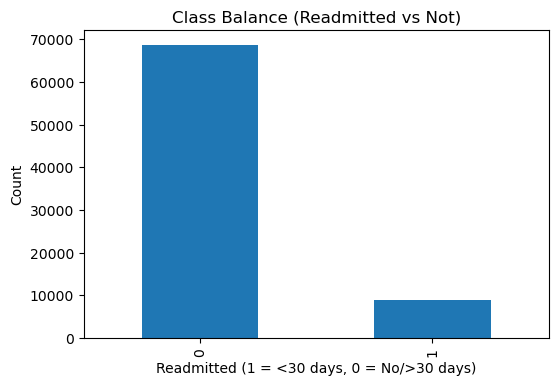

In [19]:
plt.figure(figsize=(6,4))
df['readmitted'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Balance (Readmitted vs Not)")
plt.xlabel("Readmitted (1 = <30 days, 0 = No/>30 days)")
plt.ylabel("Count")
plt.show()

In [22]:
# ----------------------------
# 8️⃣ Train-Test Split
# ----------------------------
from sklearn.model_selection import train_test_split

X = df.drop("readmitted", axis=1)
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (62079, 2295)
Test shape: (15520, 2295)


In [24]:
# ----------------------------
# 9️⃣ Feature Selection
# ----------------------------
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer

# Keep numeric features only
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test[X_train_num.columns]

# Impute missing values with median
imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)
X_test_imp = pd.DataFrame(imp.transform(X_test_num), columns=X_train_num.columns, index=X_test.index)

# Remove features with zero variance
vt = VarianceThreshold(threshold=0.0)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_imp), columns=X_train_imp.columns[vt.get_support()], index=X_train_imp.index)
X_test_vt = pd.DataFrame(vt.transform(X_test_imp), columns=X_train_imp.columns[vt.get_support()], index=X_test_imp.index)

# Select Top K Features using Mutual Information
K_TOP_FEATURES = 30
k = min(K_TOP_FEATURES, X_train_vt.shape[1])
skb = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_sel = pd.DataFrame(skb.fit_transform(X_train_vt, y_train),
                           columns=X_train_vt.columns[skb.get_support()],
                           index=X_train_vt.index)
X_test_sel = pd.DataFrame(skb.transform(X_test_vt),
                          columns=X_train_vt.columns[skb.get_support()],
                          index=X_test_vt.index)

print(f"✅ Selected Top {k} Features")

✅ Selected Top 11 Features


C:\Users\user\AppData\Local\Temp\ipykernel_7512\3332496154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="viridis")


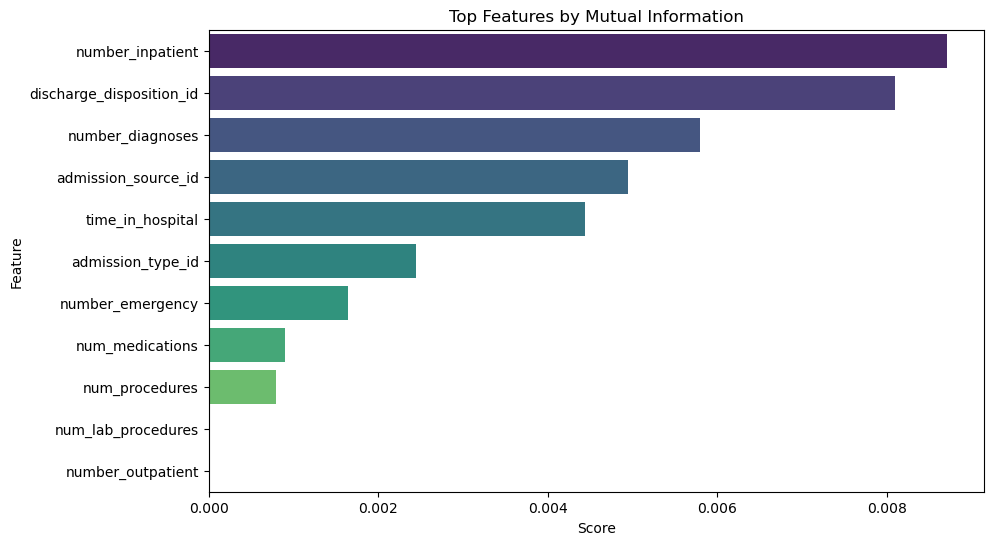

In [26]:
# ----------------------------
# 🔍 Visualization: Top Features
# ----------------------------
feature_scores = pd.Series(skb.scores_, index=X_train_vt.columns).sort_values(ascending=False)[:k]
plt.figure(figsize=(10,6))
sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="viridis")
plt.title("Top Features by Mutual Information")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.show()


In [31]:
# ----------------------------
# 🔟 Model Training & Evaluation
# ----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = []
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

print(f"{name} Results:")
print(classification_report(y_test, y_pred))
print("-" * 50)



🚀 Training Logistic Regression...

🚀 Training Decision Tree...

🚀 Training Random Forest...

🚀 Training Gradient Boosting...
Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.51      0.01      0.03      1755

    accuracy                           0.89     15520
   macro avg       0.70      0.51      0.48     15520
weighted avg       0.85      0.89      0.84     15520

--------------------------------------------------


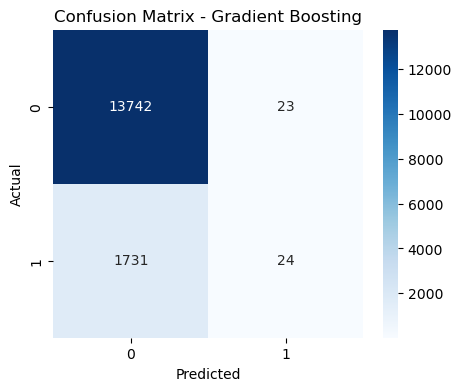

In [35]:
  # 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title(f"Confusion Matrix - {name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()